# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
import datetime
import plotly.express as px
import seaborn as sns

import fitbit
import gather_keys_oauth2 as Oauth2
import MyFitnessReport_Keys as keys

CLIENT_ID = keys.client_id
CLIENT_SECRET = keys.client_secret

# API Authorization 

In [2]:
server = Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET)
server.browser_authorize()
ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token'])
auth2_client = fitbit.Fitbit(CLIENT_ID, 
                             CLIENT_SECRET,
                             oauth2 = True,
                             access_token = ACCESS_TOKEN,
                             refresh_token = REFRESH_TOKEN)

[30/Apr/2020:15:56:05] ENGINE Listening for SIGTERM.
[30/Apr/2020:15:56:05] ENGINE Listening for SIGHUP.
[30/Apr/2020:15:56:05] ENGINE Listening for SIGUSR1.
[30/Apr/2020:15:56:05] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[30/Apr/2020:15:56:05] ENGINE Started monitor thread '_TimeoutMonitor'.
[30/Apr/2020:15:56:05] ENGINE Started monitor thread 'Autoreloader'.
[30/Apr/2020:15:56:05] ENGINE Serving on http://127.0.0.1:8080
[30/Apr/2020:15:56:05] ENGINE Bus STARTED


127.0.0.1 - - [30/Apr/2020:15:56:07] "GET /?code=020fec3c03958dd368d89d26c3bb401a347d3f67&state=MQWhE35OftGmNz3LS215nM6QIFrv7U HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.122 Safari/537.36"


[30/Apr/2020:15:56:08] ENGINE Bus STOPPING
[30/Apr/2020:15:56:13] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[30/Apr/2020:15:56:13] ENGINE Stopped thread 'Autoreloader'.
[30/Apr/2020:15:56:13] ENGINE Stopped thread '_TimeoutMonitor'.
[30/Apr/2020:15:56:13] ENGINE Bus STOPPED
[30/Apr/2020:15:56:13] ENGINE Bus EXITING
[30/Apr/2020:15:56:13] ENGINE Bus EXITED
[30/Apr/2020:15:56:13] ENGINE Waiting for child threads to terminate...


# Get Data (Activities / Heart rate)

## A Given Days Data

In [3]:
# Gets the intraday data from a given year, month, day
def intraday_heart(year = pd.datetime.now().year, month = pd.datetime.now().month, day = pd.datetime.now().day):
    try:
        date = pd.datetime(year = year, month = month, day = day)
        data = auth2_client.intraday_time_series('activities/heart', base_date = date, detail_level = '1sec')
        intra_df = pd.DataFrame(data['activities-heart-intraday']['dataset'])
        
        filename = data['activities-heart'][0]['dateTime']
        intra_df.to_csv('res/' + filename + '.csv', index = False)
        return intra_df.head()
    
    except ValueError:
        print("VALUE ERROR: Check date ( YEAR / MONTH / DAY )")

In [4]:
intraday_heart(2020, 3, 5)

,time,value
0,00:00:07,67
1,00:00:12,68
2,00:00:17,68
3,00:00:32,69
4,00:00:37,70


Text(0.5, 1.0, 'Mar 5th 2020 intradata')

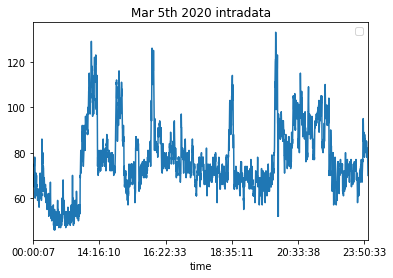

In [14]:
one_day_df = pd.read_csv("res/2020-03-05.csv")

# create and display the line plot
# one_day_graph = sns.lineplot(x=one_day_time, y=one_day_value)
# one_day_title = "Change in heartrate on March 5th 2020"
# one_day_graph.set_title(one_day_title, size = 16) 
# one_day_graph.set_xlabel("Time", size = 16)
# one_day_graph.set_ylabel("Heartrate", size = 16)

one_day_df.plot('time', 'value')
plt.legend('')
plt.title("Mar 5th 2020 intradata")

## A Given Range of Days Data

In [77]:
# Get the intraday heart data between a given start and end date
def intraday_heart_range(start_year, start_month, start_day, end_year = pd.datetime.now().year, 
                         end_month = pd.datetime.now().month, end_day = pd.datetime.now().day): 
    date_list = []
    df_list = []
    final_df_list = []
    
    try:
        start_time = pd.datetime(year = start_year, month = start_month, day = start_day)
        end_time = pd.datetime(year = end_year, month = end_month, day = end_day)
        all_dates = pd.date_range(start = start_time, end = end_time)
        
        for one_date in all_dates:
            one_date = one_date.date().strftime("%Y-%m-%d")
            data = auth2_client.intraday_time_series(
                'activities/heart', base_date = one_date, detail_level = '1sec')
            
            df = pd.DataFrame(data['activities-heart-intraday']['dataset'])
            date_list.append(one_date)
            df_list.append(df)
            
        for date, df in zip(date_list, df_list):
            if len(df) == 0:
                continue
            
            df.loc[:, 'date'] = pd.to_datetime(date)
            final_df_list.append(df)
            
        final_df = pd.concat(final_df_list, axis = 0)  
        hoursDelta = pd.to_datetime(final_df.loc[:, 'time']) \
                        .dt.hour.apply(lambda x: datetime.timedelta(hours = x))
        minutesDelta = pd.to_datetime(final_df.loc[:, 'time']) \
                        .dt.minute.apply(lambda x: datetime.timedelta(minutes = x))
        secondsDelta = pd.to_datetime(final_df.loc[:, 'time']) \
                        .dt.second.apply(lambda x: datetime.timedelta(seconds = x))
        
        final_df['date'] = final_df['date'] + hoursDelta + minutesDelta + secondsDelta
        
        filename = str(start_year) + "_" + str(start_month) + "_" + str(start_day) \
                    + "_" + str(end_year) + "_" + str(end_month) + "_" + str(end_day) 
        
        final_df.to_csv('res/' + filename + '.csv', index = False)
        
        return final_df.head()

    except ValueError:
        print("VALUE ERROR: Check date ( YEAR / MONTH / DAY )")

In [38]:
intraday_heart_range(2020, 2, 6)

,time,value,date
0,00:00:00,61,2020-02-06 00:00:00
1,00:00:05,62,2020-02-06 00:00:05
2,00:00:10,61,2020-02-06 00:00:10
3,00:00:15,63,2020-02-06 00:00:15
4,00:00:20,65,2020-02-06 00:00:20


### Data Visualizations for intradata

In [55]:
df = pd.read_csv("res/intradata_2020_2_6_2020_3_6.csv")
time = df["time"]
value = df["value"]
date = df["date"]

# To-do: Figure out what relationships you want to see for intradata
# - What times of the day does my heartrate usually spike --> compare with schedule... am I speed walking to class? xD


# Get Data (Resting HR)


In [75]:
def resting_hr(start_year, start_month, start_day, end_year = pd.datetime.now().year, 
               end_month = pd.datetime.now().month, end_day = pd.datetime.now().day): 
    resting_list = []
    date_list = []
    final_df_list = []
    
    try: 
        start = pd.datetime(year = start_year, month = start_month, day = start_day)
        end = pd.datetime(year = end_year, month = end_month, day = end_day)
        dates = pd.date_range(start = start, end = end)
        
        for one_date in dates:
            one_date = one_date.date().strftime("%Y-%m-%d")
            data = auth2_client.intraday_time_series('activities/heart', base_date = one_date, detail_level = '1sec')
            date_list.append(one_date)
            resting_list.append(data['activities-heart'][0]['value']['restingHeartRate'])
            
        print("Data Collection complete")
        
    except ValueError:
        print("VALUE ERROR: Check date ( YEAR / MONTH / DAY )")  

In [76]:
resting_hr(2020, 2, 6)

Data Collection complete
